In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets
from tqdm.notebook import tqdm
import torchvision
from torch import nn
import os
import pickle
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import NUM_PTS, CROP_SIZE
from utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from utils import ThousandLandmarksDataset
from utils import restore_landmarks_batch, create_submission
import cv2
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
PATH='contest01_data'
EXP_NAME='new_aug'

In [4]:

def train(model, loader, loss_fn, optimizer, device,scheduler):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [19]:

import albumentations as A

In [20]:
class FaceResize(A.Resize):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints_new = keypoints.copy()
        height = params["rows"]
        width = params["cols"]
        scale_x = self.width / width
        scale_y = self.height / height
        keypoints_new[:, 0] = keypoints[:, 0] * scale_x
        keypoints_new[:, 1] = keypoints[:, 1] * scale_y
        return keypoints_new    

class FaceShiftScaleRotate(A.ShiftScaleRotate):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints_new = keypoints.copy()

        height, width = params["rows"], params["cols"]
        center = (width / 2, height / 2)
        matrix = cv2.getRotationMatrix2D(center, params["angle"], params["scale"])
        matrix[0, 2] += params["dx"] * width
        matrix[1, 2] += params["dy"] * height

        keypoints_new = cv2.transform(keypoints_new[None, :, :], matrix).squeeze()
        return keypoints_new
    
class FaceSmallestMaxSize(A.SmallestMaxSize):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints_new = keypoints.copy()

        height, width = params["rows"], params["cols"]
        scale = self.max_size / min([height, width])
        keypoints_new[:, 0] = keypoints[:, 0] * scale
        keypoints_new[:, 1] = keypoints[:, 1] * scale

        return keypoints_new
    
class FaceCenterCrop(A.CenterCrop):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints_new = keypoints.copy()

        crop_height, crop_width = self.height, self.width
        height, width = params["rows"], params["cols"]
            
        y1 = (height - crop_height) // 2
        x1 = (width - crop_width) // 2
        
        keypoints_new[:, 0] = keypoints[:, 0] - x1
        keypoints_new[:, 1] = keypoints[:, 1] - y1

        return keypoints_new
    
# Source: https://www.kaggle.com/sergemsu/landmark-preserve-horizontal-flip
class FaceHorizontalFlip(A.HorizontalFlip):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints_new = keypoints.copy()
        keypoints_new[:, 0] = (params['cols'] - 1) - keypoints_new[:, 0]
        lm = keypoints_new

        nm = np.zeros_like(lm)

        nm[:64,:]     = lm[64:128,:]     # [  0, 63]  -> [ 64, 127]:  i --> i + 64
        nm[64:128,:]  = lm[:64,:]        # [ 64, 127] -> [  0, 63]:   i --> i - 64
        nm[128:273,:] = lm[272:127:-1,:] # [128, 272] -> [128, 272]:  i --> 400 - i
        nm[273:337,:] = lm[337:401,:]    # [273, 336] -> [337, 400]:  i --> i + 64
        nm[337:401,:] = lm[273:337,:]    # [337, 400] -> [273, 336]:  i --> i - 64
        nm[401:464,:] = lm[464:527,:]    # [401, 463] -> [464, 526]:  i --> i + 64
        nm[464:527,:] = lm[401:464,:]    # [464, 526] -> [401, 463]:  i --> i - 64
        nm[527:587,:] = lm[527:587,:]    # [527, 586] -> [527, 586]:  i --> i
        nm[587:714,:] = lm[714:841,:]    # [587, 713] -> [714, 840]:  i --> i + 127
        nm[714:841,:] = lm[587:714,:]    # [714, 840] -> [587, 713]:  i --> i - 127
        nm[841:873,:] = lm[872:840:-1,:] # [841, 872] -> [841, 872]:  i --> 1713 - i
        nm[873:905,:] = lm[904:872:-1,:] # [873, 904] -> [873, 904]:  i --> 1777 - i
        nm[905:937,:] = lm[936:904:-1,:] # [905, 936] -> [905, 936]:  i --> 1841 - i
        nm[937:969,:] = lm[968:936:-1,:] # [937, 968] -> [937, 968]:  i --> 1905 - i
        nm[969:971,:] = lm[970:968:-1,:] # [969, 970] -> [969, 970]:  i --> 1939 - i

        return nm

In [27]:
class LandmarksAugmentation:
    def __init__(self, rotation_limit):
        self.rotation_limit = rotation_limit

    def random_rotation(self, image, landmarks):

        angle = np.random.uniform(-self.rotation_limit, self.rotation_limit)
        image = TF.rotate(image, angle)

        landmarks = landmarks.reshape(-1, 2)
        landmarks = torch.hstack((landmarks, torch.ones((landmarks.shape[0], 1))))
        center = (CROP_SIZE / 2, CROP_SIZE / 2)
        rad = angle * np.pi / 180.0
        alpha = np.cos(rad)
        beta = np.sin(rad)
        M_torch = torch.tensor([[alpha, beta, (1-alpha)*center[0] - beta*center[1]],
                                [-beta, alpha, beta*center[0] + (1-alpha)*center[1]]], dtype=torch.float32)
        new_landmark = torch.matmul(landmarks, M_torch.T)

        return image, new_landmark
    
    def __call__(self, sample):
        image, landmarks = self.random_rotation(sample['image'], sample['landmarks'])
        sample['image'] = image
        sample['landmarks'] = landmarks.flatten()
        return sample

In [28]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
     TransformByKeys(LandmarksAugmentation(90),('image',))
])


# test_transforms = transforms.Compose([
#     ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
#     CropCenter(CROP_SIZE),
#     TransformByKeys(transforms.ToPILImage(), ("image",)),
#     TransformByKeys(transforms.ToTensor(), ("image",)),
#     TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
# ])

In [23]:
skip_images=pd.read_csv('./my_shit_images.csv',index_col=0)

In [24]:
skip_images = skip_images.iloc[:,0].map(lambda x:os.path.join(PATH, "train",'images',x)).values

In [29]:
train_dataset = ThousandLandmarksDataset(os.path.join(PATH, "train"), train_transforms, split="train")

 80%|███████▉  | 51200/64001 [00:18<00:04, 2731.54it/s]


In [30]:
train_dataset[0]

IndexError: too many indices for tensor of dimension 3

In [10]:
# for x in skip_images:
    
#     try:
#         idx = train_dataset.image_names.index(x)
#         del train_dataset.image_names[idx]
#     except:
#         continue
#     train_dataset.landmarks=  torch.cat((train_dataset.landmarks[:idx,:], train_dataset.landmarks[idx+1:,:]), axis = 0)

    

In [11]:

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=6, pin_memory=True,
                              shuffle=True, drop_last=True)
val_dataset = ThousandLandmarksDataset(os.path.join(PATH, "train"), train_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True,
                            shuffle=False, drop_last=False)

100%|██████████| 64001/64001 [00:04<00:00, 14484.35it/s] 


In [12]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
device

device(type='cuda', index=0)

In [14]:
model = torchvision.models.mobilenet_v2(pretrained=True)

In [15]:

model.requires_grad_(False)

model.classifier = nn.Linear(1280,971*2,bias=True)
model.classifier.requires_grad_(True)

model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [16]:


optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

loss_fn = fnn.mse_loss
EPOCHS=100
NUM_PREFIT_EPOCHS=3

In [17]:
device

device(type='cuda', index=0)

In [18]:
os.makedirs("runs", exist_ok=True)
best_val_loss = np.inf
for epoch in range(EPOCHS):
    if epoch>NUM_PREFIT_EPOCHS:
        model.requires_grad_(True)
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device,scheduler)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join("runs", f"{EXP_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

# 3. predict


training...:   0%|          | 0/1599 [00:00<?, ?it/s]


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ilyua/cv_made/contest1/utils.py", line 128, in __getitem__
    sample = self.transforms(sample)
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 60, in __call__
    img = t(img)
  File "/home/ilyua/cv_made/contest1/utils.py", line 73, in __call__
    sample[name] = self.transform(sample[name])
  File "<ipython-input-5-80788e600482>", line 23, in __call__
    image, landmarks = self.random_rotation(sample['image'], sample['landmarks'])
IndexError: too many indices for tensor of dimension 3


In [23]:
test_dataset = ThousandLandmarksDataset(os.path.join(PATH, "test"), train_transforms, split="test")
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=4, pin_memory=True,
                             shuffle=False, drop_last=False)

with open(os.path.join("runs", f"{EXP_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

test_predictions = predict(model, test_dataloader, device)
with open(os.path.join("runs", f"{EXP_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

create_submission(PATH, test_predictions, os.path.join("runs", f"{EXP_NAME}_submit_1.csv"))


test prediction...: 100%|██████████| 125/125 [02:33<00:00,  1.23s/it]


In [50]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [149]:
idx=200

In [150]:
origin_image=cv2.imread(train_dataset.image_names[idx])
origin_landmarks=train_dataset.landmarks[idx]

In [151]:
sample = train_dataset[idx]

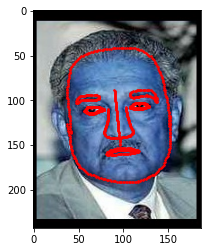

In [152]:
plt.imshow(origin_image)
plt.scatter(origin_landmarks[:, 0], origin_landmarks[:, 1], s=10, marker='.', c='r')

In [153]:
unscaled_predicitons =  model(sample['image'].unsqueeze(dim=0).to(device))[0].cpu().detach()

In [154]:
unscaled_predicitons

tensor([ 67.8997, 114.3722,  66.8194,  ...,  56.1010,  80.5654,  53.1850])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


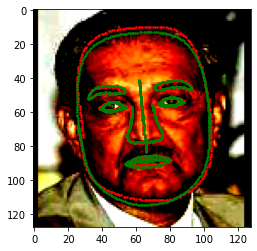

In [155]:
image = sample['image'].permute(1,2,0)
landmarks = torch.reshape(sample['landmarks'],(-1,2))
unscaled_predicitons =torch.reshape(unscaled_predicitons,(-1,2))
plt.imshow(image)
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
plt.scatter(unscaled_predicitons[:, 0], unscaled_predicitons[:, 1], s=10, marker='.', c='g')

In [156]:

def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks

In [157]:
scaled_predictions = restore_landmarks(unscaled_predicitons,sample['scale_coef'],(sample["crop_margin_x"],sample['crop_margin_y']))

In [158]:
scaled_predictions

tensor([[ 99.1972, 194.8485],
        [ 97.6189, 195.0248],
        [ 95.9383, 195.0459],
        ...,
        [ 78.6531, 160.0378],
        [ 66.8079, 109.7179],
        [117.7010, 105.4578]])

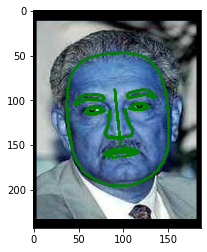

In [162]:
# image = sample['image'].permute(1,2,0)
# landmarks = torch.reshape(sample['landmarks'],(-1,2))
plt.imshow(origin_image)
# plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
plt.scatter(scaled_predictions[:, 0], scaled_predictions[:, 1], s=10, marker='.', c='g')

In [61]:
a = model(sample['image'].unsqueeze(dim=0).to(device))

In [62]:

def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks

In [63]:
# a = restore_landmarks(a,sample['scale_coef'],(sample["crop_margin_x"],sample['crop_margin_y']))

In [64]:
a

tensor([[ 67.8997, 114.3722,  66.8194,  ...,  56.1010,  80.5654,  53.1850]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [65]:
image = sample['image'].permute(1,2,0)
landmarks = torch.reshape(sample['landmarks'],(-1,2))
a = torch.reshape(a,(-1,2)).cpu().detach().numpy()

In [66]:
# plt.imshow(cv2.imread(train_dataset.image_names[200]))
# plt.scatter(train_dataset.landmarks[200][:, 0], train_dataset.landmarks[200][:, 1], s=10, marker='.', c='r')
# plt.scatter(a[:, 0], a[:, 1], s=10, marker='.', c='g')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


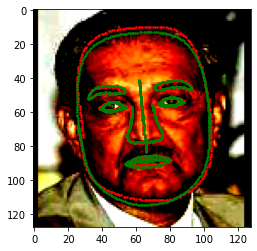

In [67]:
plt.imshow(image)
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
plt.scatter(a[:, 0], a[:, 1], s=10, marker='.', c='g')
plt.pause(0.001)

In [ ]:
predictions_test= predict(model,test_dataloader,device)

In [48]:
predictions = predict(model,test_dataloader,device)

test prediction...: 100%|██████████| 125/125 [00:15<00:00,  8.02it/s]


In [44]:
predictions

array([[[ 59.88687897, 135.13299561],
        [ 58.86968231, 135.01222229],
        [ 57.75097656, 134.89904785],
        ...,
        [ 46.96876907, 109.37329865],
        [ 42.28304672,  75.01396179],
        [ 76.02361298,  74.49243927]],

       [[ 72.90974426, 150.03695679],
        [ 71.11503601, 149.83509827],
        [ 69.71733093, 149.63717651],
        ...,
        [ 60.03791046, 120.21196747],
        [ 56.92360687,  77.33120728],
        [ 91.28969574,  78.29720306]],

       [[ 63.49426651, 160.06442261],
        [ 62.12126541, 159.48020935],
        [ 60.72234344, 159.67228699],
        ...,
        [ 54.02402878, 126.08144379],
        [ 51.55233002,  80.80749512],
        [ 81.03530121,  81.94937897]],

       ...,

       [[ 93.95404053, 176.90644836],
        [ 92.4677124 , 177.24752808],
        [ 90.57542419, 177.23895264],
        ...,
        [ 73.09829712, 143.6546936 ],
        [ 63.1435318 ,  95.44393921],
        [110.90291595,  92.6407547 ]],

       [[ 60.80

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


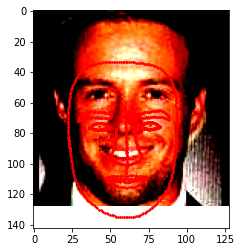

In [45]:
show_landmarks(test_dataset[0]['image'].permute(1,2,0),predictions[0])

# Submission

In [11]:
test_dataset = datasets.ImageFolder('contest01_data/test/')

In [16]:
points = pd.read_csv('contest01_data/test/test_points.csv',sep='\t')

In [ ]:
DataLoader(dataset, batch_size=1,

In [ ]:
def make_submission(model,test_dataloader,points,submission_name='test'):
    for img_name in tqdm(points['file_name'].values):
        predicted_landmarks = model(torch.Tensor(io.read_image(img_name)))
        ####